# Introduction and Setup

This notebook utilizes a CycleGAN architecture to add Monet-style to photos. For this tutorial, we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU.

For more information, check out [TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan) and [Keras](https://keras.io/examples/generative/cyclegan/) CycleGAN documentation pages.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

import gc

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path("monet-gan-getting-started") 

# TFRECORDS

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [7]:
monet_ds = load_dataset(MONET_FILENAMES[:3], labeled=True).batch(1) ########### only 3 first paths, only to test
photo_ds = load_dataset(PHOTO_FILENAMES[:3], labeled=True).batch(1) ########### only 3 first paths, only to test

In [8]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

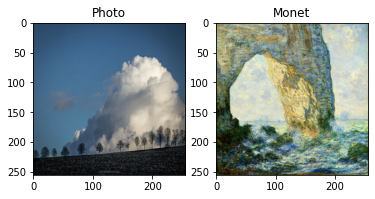

In [9]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

convert jpeg to tfrecord

In [10]:
# from tqdm import tqdm
# import tensorflow.compat.v1 as tf1
# import skimage
# import skimage.io
# import os

# # Note: modified from source
# def _int64_feature(value):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# def _bytes_feature(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# # images and labels array as input
# def convert_to(images, labels, output_directory, name):
#     num_examples = labels.shape[0]
#     if images.shape[0] != num_examples:
#         raise ValueError("Images size %d does not match label size %d." %
#                          (images.shape[0], num_examples))
#     rows = images.shape[1]
#     cols = images.shape[2]
#     depth = images.shape[3]

#     filename = os.path.join(output_directory, name + '.tfrecords')
#     print('Writing', filename)
#     writer = tf1.python_io.TFRecordWriter(filename)
#     for index in range(num_examples):
# #         filename = os.path.join(output_directory, str(labels[index]) + '.tfrecords')###########suprim
# #         writer = tf1.python_io.TFRecordWriter(filename)########################"suprim"
#         image_raw = images[index].tobytes()
#         example = tf.train.Example(features=tf.train.Features(feature={
#             'height': _int64_feature(rows),
#             'width': _int64_feature(cols),
#             'depth': _int64_feature(depth),
#             'label': _int64_feature(int(labels[index])),
#             'image_raw': _bytes_feature(image_raw)}))
#         writer.write(example.SerializeToString())
    
# def read_image(file_name, images_path):
#     image = skimage.io.imread(images_path + file_name)
#     return image

# def extract_image_index_make_label(img_name):
#     label = img_name.split(".")[0]
# #     name, serie, repetition, char = remove_ext.split("_")
# #     label = int(char) + 1000 * int(repetition) + 1000_000 * int(serie)
#     return label

# images_path = "../input/monet-gan-getting-started/monet_jpg/"
# image_list = os.listdir(images_path)
# images = []
# labels = []
# for img_name in tqdm(image_list):
#     images.append(read_image(img_name, images_path))
# #     labels.append(extract_image_index_make_label(img_name))
# labels = list(np.arange(len(images)))
# images_array = np.array(images)
# labels = np.array(labels)

# print(images_array.shape, labels.shape)

# convert_to(images_array, labels, ".", "./monet_jpg_to_tfrec")

# JPEG

In [11]:
from keras.preprocessing.image import img_to_array
from PIL import Image
import os
import cv2

paths = ['../input/monet-gan-getting-started/photo_jpg/',
         '../input/monet-gan-getting-started/monet_jpg/']

def get_monet(path) :
    
    x = []
    for img_path in os.listdir(path)[:5555] :
        
        im = img_to_array(Image.fromarray(cv2.cvtColor(cv2.imread(
            os.path.join(path, img_path)), cv2.COLOR_BGR2RGB)))
        
#         im = (np.array(im)/10).astype(np.int8).astype(np.float32)
#         im /= 25.
        im /= 255.0
        im = np.round(im, 1)
        
        im = cv2.resize(im, (256, 256))
        
        x.append(im)
        
#     #convert range [0:255] to [10:250]
#     x = np.array(x)+15
#     x /= 270.0
#     x = x - 19.6e-3
    
    return np.array(x)
y = get_monet(paths[0])

In [12]:
def get_img(path) :
    
    x = []
    for img_path in os.listdir(path)[:] :
        
        im = img_to_array(Image.fromarray(cv2.cvtColor(cv2.imread(
            os.path.join(path, img_path)), cv2.COLOR_BGR2RGB)))
        
        im = np.repeat(np.expand_dims(im.mean(axis=-1), -1), 3, -1)
        im /= 255.0
        im = np.round(im, 1)
# #         im = cv2.resize(im[:,:,::-1], (256, 256))
        x.append(im)    
    
    return np.array(x)

X = get_img(paths[0])

In [13]:
print(X.shape)
print(y.shape)

print(X.min())
print(X.max())

print(y.min())
print(y.max())

(7038, 256, 256, 3)
(5555, 256, 256, 3)
0.0
1.0
0.0
1.0


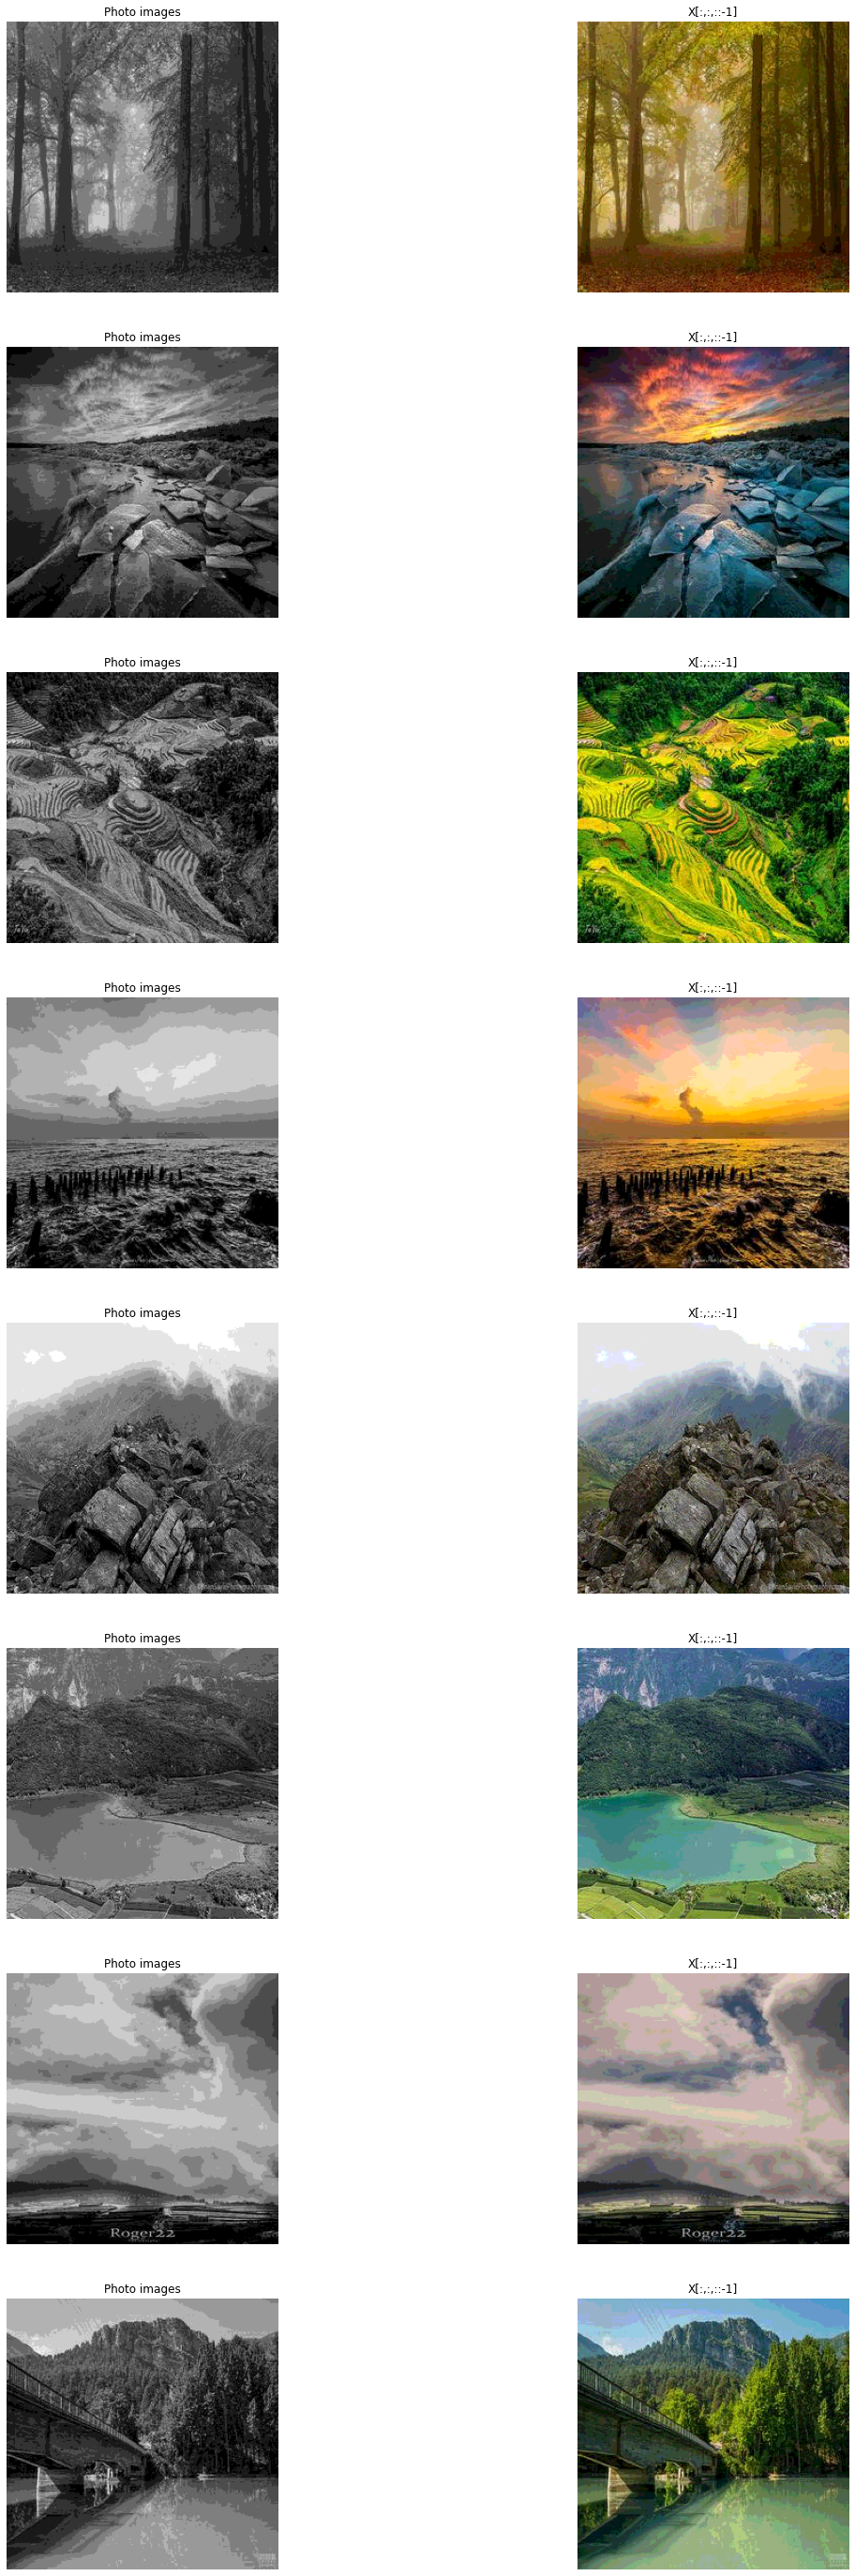

In [14]:
plt.figure(figsize = (20,50))

i = 0

while i < 16 :
    
    plt.subplot(8,2,i+1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title('Photo images')
    
    imgx1 = y[i].copy()
    imgx2 = y[i].copy()
    imgx3 = y[i].copy()
    
#     plt.subplot(8,4,i+2)
#     imgx1[:,:,1] = abs(imgx1[:,:,1]-1)
#     plt.imshow(imgx1)
#     plt.axis('off')
#     plt.title('Monet images')
    
#     plt.subplot(8,4,i+3)
#     imgx2[:,:,2] = abs(imgx1[:,:,2]-1)
#     plt.imshow(imgx2)
#     plt.axis('off')
#     plt.title('y[:,:,::-1]')
    
        
    plt.subplot(8,2,i+2)
#     imgx3[:,:,0] = abs(imgx3[:,:,0]-1)
#     imgx3[:,:,1] = abs(imgx3[:,:,1]-1)
#     imgx3 = np.repeat(np.expand_dims(imgx3.mean(axis=-1), -1), 3, -1)
#     plt.imshow(imgx3)
    plt.imshow(y[i])
    plt.axis('off')
    plt.title('X[:,:,::-1]')
 
    i += 2

In [15]:
photo_ds = tf.data.Dataset.from_tensor_slices(X[:])
photo_ds = photo_ds.shuffle(1000).batch(1)
del X

In [16]:
monet_ds = tf.data.Dataset.from_tensor_slices(y[:])
monet_ds = monet_ds.shuffle(1000).batch(1)
del y

In [17]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

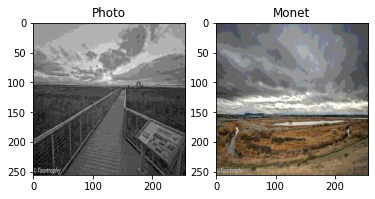

In [18]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0])

plt.subplot(122)
plt.title('Monet')
# plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.imshow(example_monet[0])

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [19]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=True))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [20]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=True))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [21]:
def Monet_Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='sigmoid') # (bs, 256, 256, 3)
#                                   activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [22]:
class RoundLayer(tf.keras.layers.Layer):
  def call(self, inputs):
    self.add_loss(tf.round(inputs*10.)/10.)
    return inputs
l = RoundLayer()
l(np.ones((10, 1)))
l.losses[0].numpy()

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [23]:
def Photo_Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='sigmoid') # (bs, 256, 256, 3)
    
    
    round_output = RoundLayer()
    

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    x = round_output(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [24]:
# def Discriminator():
#     initializer = tf.random_normal_initializer(0., 0.02)
#     gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#     inp = layers.Input(shape=[256, 256, 3], name='input_image')

#     x = inp

#     down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
#     down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
#     down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

#     zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
#     conv = layers.Conv2D(512, 4, strides=1,
#                          kernel_initializer=initializer,
#                          use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

#     norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

#     leaky_relu = layers.LeakyReLU()(norm1)

#     zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

#     last = layers.Conv2D(1, 4, strides=1,
#                          activation='sigmoid',
#                          kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

#     return tf.keras.Model(inputs=inp, outputs=last)


def Discriminator():
    initializer = tf.random_normal_initializer(0.001, 0.05)
    gamma_init = keras.initializers.RandomNormal(mean=0.50, stddev=0.002)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 2, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 2)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 2)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 2, strides=1,
                         kernel_initializer=initializer,
                         use_bias=True)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         activation='sigmoid',
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [25]:
with strategy.scope():
    monet_generator = Monet_Generator() # transforms photos to Monet-esque paintings
    photo_generator = Photo_Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

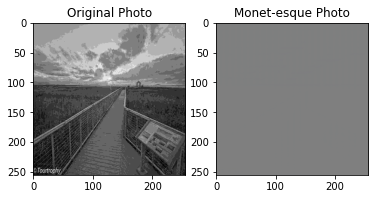

In [26]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0])

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
# plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.imshow(to_monet[0])
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [27]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            
            
            
            
            
            
            
            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            """# evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            """
            
            
            # evaluates total cycle consistency loss
            total_cycle_loss_monet = self.cycle_loss_fn(cycled_monet, real_monet, self.lambda_cycle) 
            total_identity_loss_photo = self.identity_loss_fn(same_photo, real_photo, self.lambda_cycle)
            
#             total_cycle_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
#             total_identity_loss_monet = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            
            total_cycle_loss_photo = self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_identity_loss_monet = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            
#             # evaluates total generator loss
#             total_monet_gen_loss = monet_gen_loss + total_cycle_loss_monet + total_identity_loss_monet + total_cycle_loss_photo
#             total_photo_gen_loss = photo_gen_loss + total_cycle_loss_photo + total_identity_loss_monet + total_cycle_loss_monet
            
            
            # evaluates total generator loss
            total_monet_gen_loss = 3*monet_gen_loss + 2*total_cycle_loss_monet + total_cycle_loss_photo + 2*total_identity_loss_monet 
            total_photo_gen_loss = 3*photo_gen_loss + 2*total_cycle_loss_photo + total_cycle_loss_monet + 2*total_identity_loss_photo
            
            
            """original code above inside the cotes. The code just above this is ironic, just to check the results"""
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [28]:
# with strategy.scope():
#     def discriminator_loss(real, generated):
# #         real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
# #         generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

#         real_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real>0.5), real)
#         generated_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated>0.5), generated)
      
#         total_disc_loss = (real_loss + generated_loss) * 0.5
        
#         return total_disc_loss 


with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real>0.5), real)
        generated_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated>0.5), generated)
      
        total_disc_loss = (real_loss + generated_loss) * 0.5
        
        return total_disc_loss 

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [29]:
with strategy.scope():
    def generator_loss(generated):        
#         return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated>.5), generated)
#         g_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated>.5), generated)
        g_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated>.5), generated)
            
        return g_loss

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [30]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

#         axis_0 = tf.experimental.numpy.isclose(real_image, cycled_image, rtol=1e-05, atol=1e-08)
#         axis_0 = cycled_image * tf.cast(axis_0, tf.float32)  
        
#         cycled_image_roll_1 = tf.roll(cycled_image, shift=-1, axis=3)
#         axis_1 = tf.experimental.numpy.isclose(real_image, cycled_image_roll_1, rtol=1e-05, atol=1e-08)
#         axis_1 = cycled_image_roll_1 * tf.cast(axis_1, tf.float32)
        
#         cycled_image_roll_2 = tf.roll(cycled_image, shift=-2, axis=3)
#         axis_2 = tf.experimental.numpy.isclose(real_image, cycled_image_roll_2, rtol=1e-05, atol=1e-08)
#         axis_2 = cycled_image_roll_2 * tf.cast(axis_2, tf.float32)
        
        
#         cycled_image_rolled = tf.reduce_mean([axis_0, axis_1, axis_2], axis=0)
#         cycled_image_zeros = tf.zeros_like(cycled_image_rolled)
        
#         cycled_image_zeros = cycled_image  * tf.cast(cycled_image_zeros, tf.float32)
#         cycled_image_rolled = cycled_image_rolled + cycled_image_zeros
        
#         loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [31]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))

        
#         axis_0 = tf.experimental.numpy.isclose(real_image, same_image, rtol=1e-05, atol=1e-08)
#         axis_0 = same_image * tf.cast(axis_0, tf.float32)  
        
#         same_image_roll_1 = tf.roll(same_image, shift=-1, axis=3)
#         axis_1 = tf.experimental.numpy.isclose(real_image, same_image_roll_1, rtol=1e-05, atol=1e-08)
#         axis_1 = same_image_roll_1 * tf.cast(axis_1, tf.float32)
        
#         same_image_roll_2 = tf.roll(same_image, shift=-2, axis=3)
#         axis_2 = tf.experimental.numpy.isclose(real_image, same_image_roll_2, rtol=1e-05, atol=1e-08)
#         axis_2 = same_image_roll_2 * tf.cast(axis_2, tf.float32)
        
        
#         same_image_rolled = tf.reduce_mean([axis_0, axis_1, axis_2], axis=0)
#         same_image_zeros = tf.zeros_like(same_image_rolled)
        
#         same_image_zeros = same_image  * tf.cast(same_image_zeros, tf.float32)
#         same_image_rolled = same_image_rolled + same_image_zeros
        
#         loss = tf.reduce_mean(tf.abs(real_image - same_image_rolled))
        
        return LAMBDA * 0.5 * loss

___

In [32]:
# with strategy.scope():
#     def calc_cycle_loss(real_image, cycled_image, LAMBDA):
# #         loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

#         axis_0 = tf.experimental.numpy.isclose(real_image, cycled_image, atol=20e-02)
#         axis_0 = tf.cast(axis_0, tf.float32)  
        
#         cycled_image_roll_1 = tf.roll(cycled_image, shift=-1, axis=3)
#         axis_1 = tf.experimental.numpy.isclose(real_image, cycled_image_roll_1, atol=20e-02)
#         axis_1 = tf.cast(tf.roll(axis_1, shift=1, axis=3), tf.float32)
        
#         cycled_image_roll_2 = tf.roll(cycled_image, shift=-2, axis=3)
#         axis_2 = tf.experimental.numpy.isclose(real_image, cycled_image_roll_2, atol=20e-02)
#         axis_2 = tf.cast(tf.roll(axis_2, shift=2, axis=3), tf.float32)
        
        
#         cycled_image_rolled = tf.reduce_max([axis_0, axis_1, axis_2], axis=0) 
        
#         cycled_image_rolled =  cycled_image_rolled * real_image
#         cycled_image_zeros = tf.zeros_like(cycled_image_rolled)
        
#         cycled_image_zeros = cycled_image  * tf.cast(cycled_image_zeros, tf.float32)
#         cycled_image_rolled = cycled_image_rolled + cycled_image_zeros
        
#         loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
#         loss1 = LAMBDA * loss1
        
#         return loss1
    
# with strategy.scope():
#     def identity_loss(real_image, same_image, LAMBDA):
# #         loss = tf.reduce_mean(tf.abs(real_image - same_image))

        
#         axis_0 = tf.experimental.numpy.isclose(real_image, same_image, atol=20e-02)
#         axis_0 = tf.cast(axis_0, tf.float32)  
        
#         same_image_roll_1 = tf.roll(same_image, shift=-1, axis=3)
#         axis_1 = tf.experimental.numpy.isclose(real_image, same_image_roll_1, atol=20e-02)
#         axis_1 = tf.cast(tf.roll(axis_1, shift=1, axis=3), tf.float32)
        
#         same_image_roll_2 = tf.roll(same_image, shift=-2, axis=3)
#         axis_2 = tf.experimental.numpy.isclose(real_image, same_image_roll_2, atol=20e-02)
#         axis_2 = tf.cast(tf.roll(axis_2, shift=2, axis=3), tf.float32)
        
        
#         same_image_rolled = tf.reduce_max([axis_0, axis_1, axis_2], axis=0) 
        
        
#         same_image_rolled = same_image_rolled * real_image
#         same_image_zeros = tf.zeros_like(same_image_rolled)
        
#         same_image_zeros = same_image * tf.cast(same_image_zeros, tf.float32)
#         same_image_rolled = same_image_rolled + same_image_zeros
        
#         loss = tf.reduce_mean(tf.abs(real_image - same_image_rolled))

        
#         loss = LAMBDA * 0.5 * loss
        
#         return loss 

In [33]:
# # ############################################################################################
# # ############ (REAL AND CYCLED) AND (REAL AND SAME) IMAGE POSITIONS ARE INVERSED ############
# # ############################################################################################
# with strategy.scope():
#     def calc_cycle_loss(real_image, cycled_image, LAMBDA):
# #         loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
# #         real_image = real_image +.2
# #         real_image = real_image /1.2
# #         real_image = real_image -.12
        
#         axis_0 = tf.experimental.numpy.isclose(real_image, cycled_image, atol=96e-3)
#         axis_0 = tf.cast(axis_0, tf.float32)  
        
#         cycled_image_roll_1 = tf.roll(cycled_image, shift=-1, axis=3)
#         axis_1 = tf.experimental.numpy.isclose(real_image, cycled_image_roll_1, atol=96e-3)
#         axis_1 = tf.cast(tf.roll(axis_1, shift=1, axis=3), tf.float32)
# #         axis_1 = tf.cast(axis_1, tf.float32)
        
#         cycled_image_roll_2 = tf.roll(cycled_image, shift=-2, axis=3)
#         axis_2 = tf.experimental.numpy.isclose(real_image, cycled_image_roll_2, atol=96e-3)
#         axis_2 = tf.cast(tf.roll(axis_2, shift=2, axis=3), tf.float32)
# #         axis_2 = tf.cast(axis_2, tf.float32)
        
        
#         cycled_image_rolled = tf.reduce_max([axis_0, axis_1, axis_2], axis=0) 
#         cycled_image_rolled = tf.reduce_max(cycled_image_rolled, axis=-1)
#         cycled_image_rolled = tf.expand_dims(cycled_image_rolled, -1)
#         cycled_image_rolled = tf.repeat(cycled_image_rolled, repeats=3, axis=-1)
# #         cycled_image_rolled = tf.cast(cycled_image_rolled, tf.float32) 
        
#         cycled_image_rolled =  cycled_image_rolled * real_image
#         cycled_image_zeros = tf.zeros_like(cycled_image_rolled)
        
#         cycled_image_zeros = cycled_image  * tf.cast(cycled_image_zeros, tf.float32)
#         cycled_image_rolled = cycled_image_rolled + cycled_image_zeros
        
#         loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
#         loss1 = LAMBDA * loss1
        
#         return loss1
    
# # with strategy.scope():
# #     def identity_loss(real_image, same_image, LAMBDA):
# # #         loss = tf.reduce_mean(tf.abs(real_image - same_image))

        
# #         axis_0 = tf.experimental.numpy.isclose(real_image, same_image, atol=20e-02)
# #         axis_0 = tf.cast(axis_0, tf.float32)  
        
# #         same_image_roll_1 = tf.roll(same_image, shift=-1, axis=3)
# #         axis_1 = tf.experimental.numpy.isclose(real_image, same_image_roll_1, atol=20e-02)
# #         axis_1 = tf.cast(tf.roll(axis_1, shift=1, axis=3), tf.float32)
# # #         axis_1 = tf.cast(axis_1, tf.float32)
    
    
# #         same_image_roll_2 = tf.roll(same_image, shift=-2, axis=3)
# #         axis_2 = tf.experimental.numpy.isclose(real_image, same_image_roll_2, atol=20e-02)
# #         axis_2 = tf.cast(tf.roll(axis_2, shift=2, axis=3), tf.float32)
# # #         axis_2 = tf.cast(axis_2, tf.float32)
        
        
# #         same_image_rolled = tf.reduce_max([axis_0, axis_1, axis_2], axis=0) 
# # #         same_image_rolled = tf.reduce_max(same_image_rolled, axis=-1)
# # #         same_image_rolled = tf.expand_dims(same_image_rolled, -1)
# # #         same_image_rolled = tf.repeat(same_image_rolled, repeats=3, axis=-1)
        
# #         same_image_rolled = same_image_rolled * real_image
# #         same_image_zeros = tf.zeros_like(same_image_rolled)
        
# #         same_image_zeros = same_image * tf.cast(same_image_zeros, tf.float32)
# #         same_image_rolled = same_image_rolled + same_image_zeros
        
# #         loss = tf.reduce_mean(tf.abs(real_image - same_image_rolled))

        
# #         loss = LAMBDA * 0.5 * loss
        
# #         return loss

# with strategy.scope():
#     def identity_loss(real_image, same_image, LAMBDA):
# #         loss = tf.reduce_mean(tf.abs(real_image - same_image))
# #         real_image = real_image +.2
# #         real_image = real_image /1.2
# #         real_image = real_image -.12
        
#         axis_0 = tf.experimental.numpy.isclose(real_image, same_image, atol=96-3)
#         axis_0 = tf.cast(axis_0, tf.float32)  
        
#         same_image_roll_1 = tf.roll(same_image, shift=-1, axis=3)
#         axis_1 = tf.experimental.numpy.isclose(real_image, same_image_roll_1, atol=96e-3)
#         axis_1 = tf.cast(tf.roll(axis_1, shift=1, axis=3), tf.float32)
# #         axis_1 = tf.cast(axis_1, tf.float32)
    
    
#         same_image_roll_2 = tf.roll(same_image, shift=-2, axis=3)
#         axis_2 = tf.experimental.numpy.isclose(real_image, same_image_roll_2, atol=96e-3)
#         axis_2 = tf.cast(tf.roll(axis_2, shift=2, axis=3), tf.float32)
# #         axis_2 = tf.cast(axis_2, tf.float32)
        
        
#         same_image_rolled = tf.reduce_max([axis_0, axis_1, axis_2], axis=0) 
#         same_image_rolled = tf.reduce_max(same_image_rolled, axis=-1)
#         same_image_rolled = tf.expand_dims(same_image_rolled, -1)
#         same_image_rolled = tf.repeat(same_image_rolled, repeats=3, axis=-1)
        
#         same_image_rolled = same_image_rolled * real_image
#         same_image_zeros = tf.zeros_like(same_image_rolled)
        
#         same_image_zeros = same_image * tf.cast(same_image_zeros, tf.float32)
#         same_image_rolled = same_image_rolled + same_image_zeros
        
#         loss = tf.reduce_mean(tf.abs(real_image - same_image_rolled))

        
#         loss = LAMBDA * 0.5 * loss
        
#         return loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [34]:
# with strategy.scope():
#     monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#     photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#     monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
#     photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)

In [35]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [36]:
class EarlyStopping_custom(tf.keras.callbacks.EarlyStopping):

    def __init__(self,monitor,mode,patience,
                 restore_best_weights=True):
        super(EarlyStopping_custom, self).__init__()
        self.restore_best_weights = restore_best_weights
        self.monitor = monitor,
        self.mode = mode,
        self.patience,
        
    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return
        if self.monitor_op(current.mean() - self.min_delta, self.best):
            self.best = current.mean()
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of the best epoch.')
                    self.model.set_weights(self.best_weights)


early_stoping = EarlyStopping_custom(monitor='monet_disc_loss',
                                                 patience=5,
                                                 mode = 'min',
                                                 restore_best_weights=True)

In [37]:
import time

In [ ]:
%%time

hist = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs = 17 # 250 in 6H
    #callbacks = [early_stoping],
)

Epoch 1/17
5555/5555 [==============================] - 1345s 234ms/step - monet_gen_loss: 6.6216 - photo_gen_loss: 6.1111 - monet_disc_loss: 0.1690 - photo_disc_loss: 0.1637
Epoch 2/17
5555/5555 [==============================] - 1300s 234ms/step - monet_gen_loss: 3.9610 - photo_gen_loss: 3.4778 - monet_disc_loss: 0.2194 - photo_disc_loss: 0.2216
Epoch 3/17
5555/5555 [==============================] - 1299s 234ms/step - monet_gen_loss: 3.0834 - photo_gen_loss: 2.7463 - monet_disc_loss: 0.2377 - photo_disc_loss: 0.2388
Epoch 4/17
5555/5555 [==============================] - 1299s 234ms/step - monet_gen_loss: 2.7776 - photo_gen_loss: 2.4096 - monet_disc_loss: 0.2295 - photo_disc_loss: 0.2433
Epoch 5/17
5555/5555 [==============================] - 1299s 234ms/step - monet_gen_loss: 2.9304 - photo_gen_loss: 2.3666 - monet_disc_loss: 0.2030 - photo_disc_loss: 0.2352
Epoch 6/17
5555/5555 [==============================] - 1299s 234ms/step - monet_gen_loss: 3.2392 - photo_gen_loss: 2.4203 - 

In [40]:
gc.collect()

23

In [41]:
monet_gen_loss = np.concatenate(np.concatenate(np.concatenate(hist.history["monet_gen_loss"])))
photo_gen_loss = np.concatenate(np.concatenate(np.concatenate(hist.history["photo_gen_loss"])))
monet_disc_loss = np.concatenate(np.concatenate(np.concatenate(hist.history["monet_disc_loss"])))
photo_disc_loss = np.concatenate(np.concatenate(np.concatenate(hist.history["photo_disc_loss"])))

NameError: name 'hist' is not defined

In [ ]:
plt.plot(monet_gen_loss)
plt.plot(photo_gen_loss)

plt.title("Model Evaluation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Generator (Photo -> Monet)", "Generator (Monet -> Photo)"])

plt.show()

In [ ]:
plt.plot(monet_disc_loss)
plt.plot(photo_disc_loss)

plt.title("Model Evaluation")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Monet Discriminator", "Photo Discriminator"])

plt.show()

In [42]:
mkdir "./model"

In [43]:
# Save models
"""keras.models.save_model(monet_generator, './model/monet_generator.h5')
keras.models.save_model(photo_generator, './model/photo_generator.h5')
keras.models.save_model(monet_discriminator, './model/monet_discriminator.h5')
keras.models.save_model(photo_discriminator, './model/photo_discriminator.h5')  """

"keras.models.save_model(monet_generator, './model/monet_generator.h5')\nkeras.models.save_model(photo_generator, './model/photo_generator.h5')\nkeras.models.save_model(monet_discriminator, './model/monet_discriminator.h5')\nkeras.models.save_model(photo_discriminator, './model/photo_discriminator.h5')  "

# Visualize our Monet-esque photos

0.0020486368 0.99999976
9.465856e-05 0.9991824
0.00017453435 0.99999964
0.00060111505 0.999923
0.0008196465 0.9991943


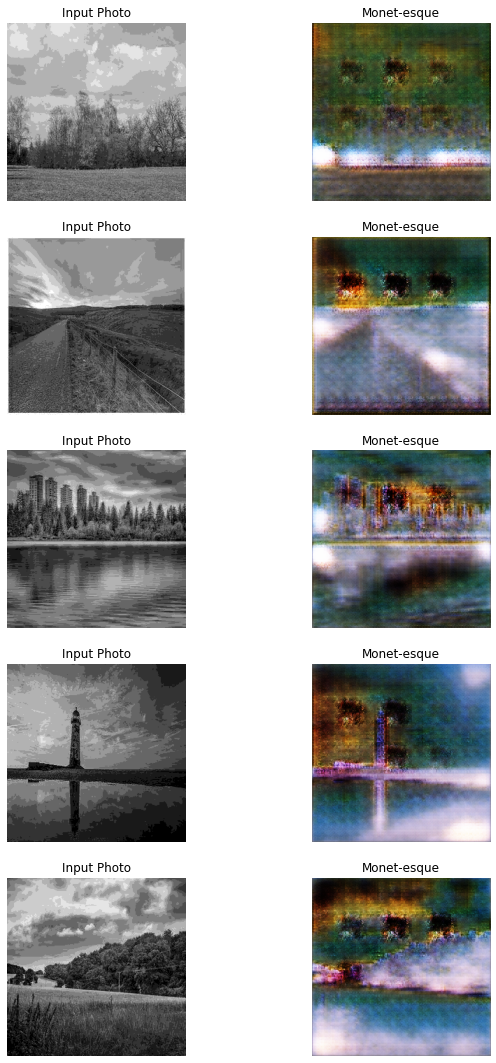

In [44]:
_, ax = plt.subplots(5, 2, figsize=(10, 19))

for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    print(prediction.min(), prediction.max())
    img = (img[0] * 255).numpy().astype(np.uint8)
#     prediction = (prediction  * 127.5 + 127.5).astype(np.uint8)
    prediction = (prediction  * 255).astype(np.uint8)
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [45]:
print(img.min(), img.max())
prediction.min(), prediction.max()

0 229


(0, 254)

7.16173e-08 0.98301077
1.056727e-06 0.999845
5.001796e-06 0.9917372
0.0006232253 0.90798587
6.2937606e-09 0.99970067


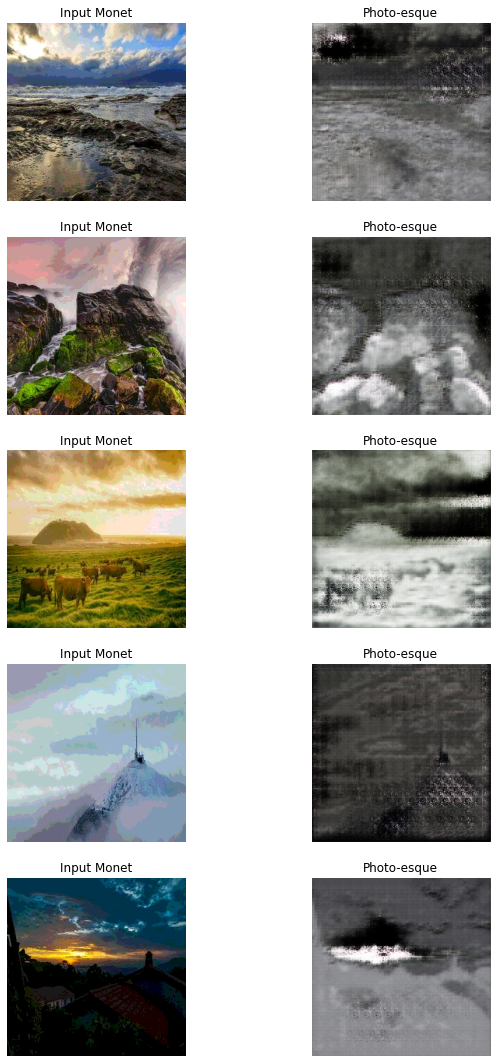

In [46]:
_, ax = plt.subplots(5, 2, figsize=(10, 19))
for i, img in enumerate(monet_ds.take(5)):
    prediction = photo_generator(img, training=False)[0].numpy()
    print(prediction.min(), prediction.max())
#     img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    img = (img[0] * 255).numpy().astype(np.uint8)
    prediction = (prediction * 255).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Monet")
    ax[i, 1].set_title("Photo-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [47]:
print(img.min(), img.max())
prediction.min(), prediction.max()

0 255


(0, 254)

Photo_generator 2.264411e-05 0.9991732
Monet_generator 4.0258907e-05 0.9999474
discrim_prediction 0.11331209 0.999936
Photo_generator 0.0012181794 0.9654165
Monet_generator 7.777826e-06 0.99991703
discrim_prediction 0.047628652 0.99948585
Photo_generator 6.672411e-08 0.9970169
Monet_generator 0.024466973 0.9999405
discrim_prediction 0.19892614 0.9999572
Photo_generator 1.6597102e-08 0.9999893
Monet_generator 0.010823526 1.0
discrim_prediction 0.14584476 0.99942744
Photo_generator 0.0015820703 0.9613114
Monet_generator 0.000871117 0.9999982
discrim_prediction 0.1378502 0.9999677


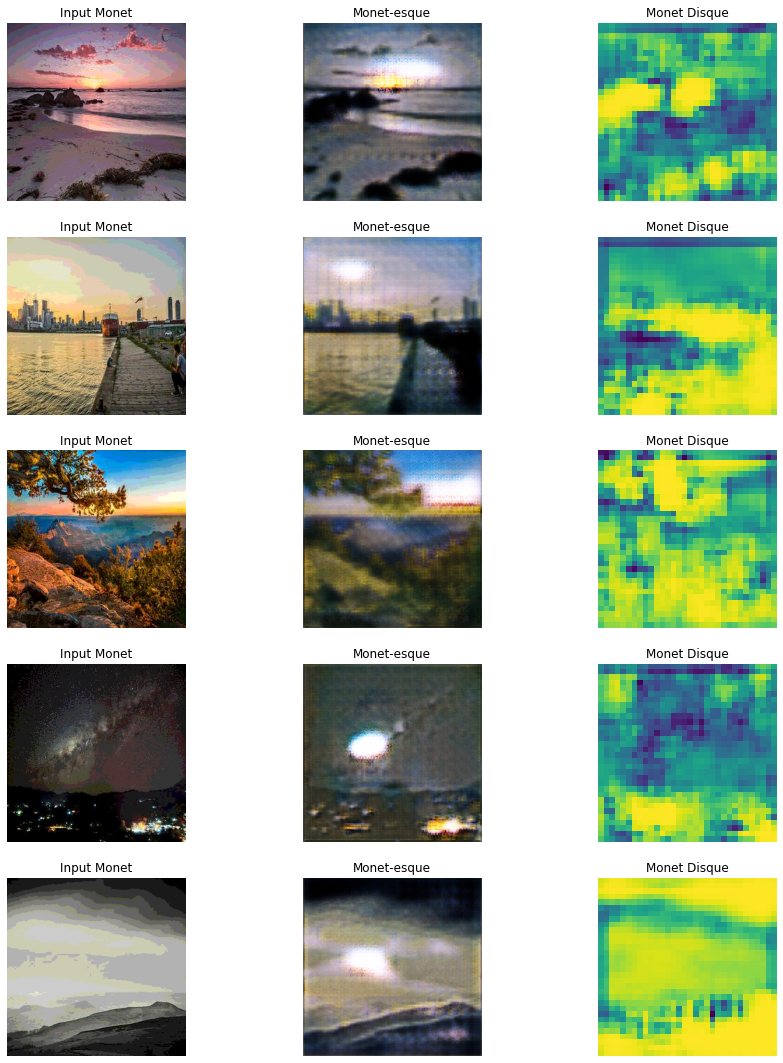

In [48]:
_, ax = plt.subplots(5, 3, figsize=(15, 19))

for i, img in enumerate(monet_ds.take(5)):
    prediction = photo_generator(img, training=False)[0].numpy()
    print('Photo_generator', prediction.min(), prediction.max())
    
    prediction = prediction.reshape((1, 256, 256, 3))
    prediction = monet_generator(prediction, training=False)[0].numpy()
    print('Monet_generator', prediction.min(), prediction.max())

    discrim_prediction = monet_discriminator(img, training=False)[0].numpy()
    print('discrim_prediction', discrim_prediction.min(), discrim_prediction.max())
    
#     discrim_prediction = (discrim_prediction  * 127.5 + 127.5).astype(np.uint8)
#     img = (img  * 127.5 + 127.5).numpy().squeeze().astype(np.uint8)
#     prediction = (prediction  * 127.5 + 127.5).astype(np.uint8)
    discrim_prediction = (discrim_prediction  * 255).astype(np.uint8)
    img = (img  * 255).numpy().squeeze().astype(np.uint8)
    prediction = (prediction  * 255).astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(discrim_prediction)
    ax[i, 0].set_title("Input Monet")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 2].set_title("Monet Disque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()

monet_generator 0.013265783 0.9999999
photo_generator 1.2768693e-08 0.9269041
discrim_prediction 0.16504294 0.91438913
monet_generator 0.00067989016 0.9997688
photo_generator 2.339903e-06 0.9996586
discrim_prediction 0.25927225 0.99978715
monet_generator 2.718717e-05 0.9998951
photo_generator 4.510656e-08 0.9832676
discrim_prediction 0.12003224 0.99506146
monet_generator 0.0013742894 0.9999995
photo_generator 1.6616555e-07 0.9881847
discrim_prediction 0.032183375 0.99838126
monet_generator 0.005693684 0.9999995
photo_generator 1.8428037e-07 0.98841
discrim_prediction 0.08225704 0.99279505


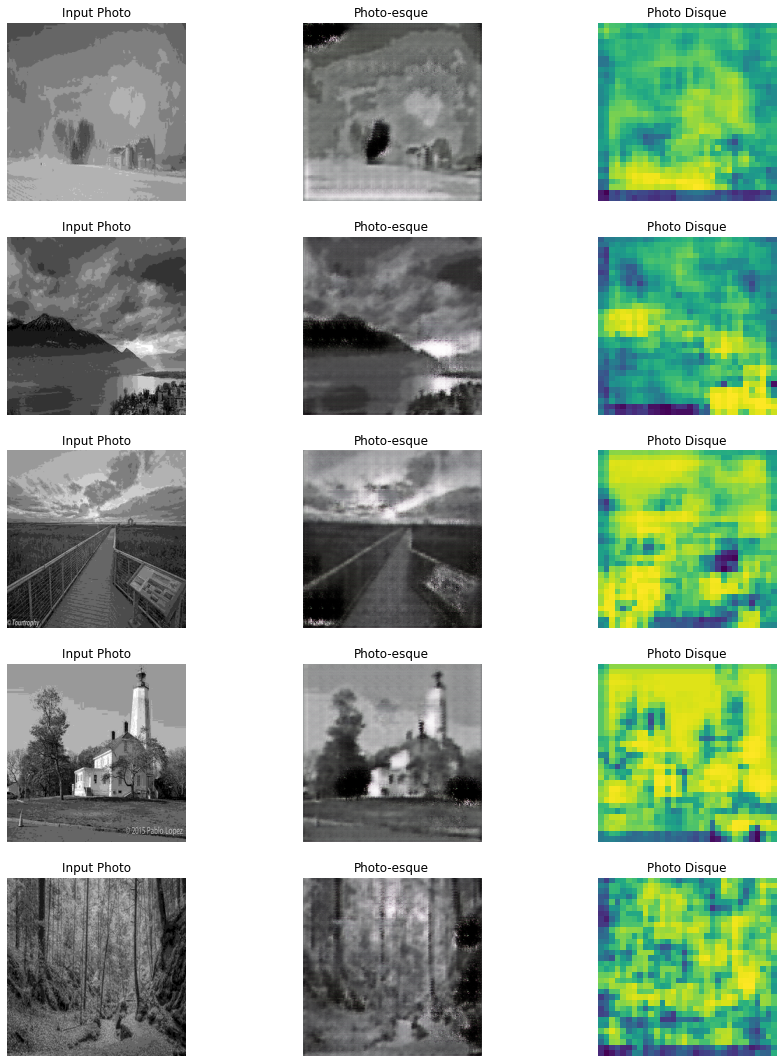

In [49]:
_, ax = plt.subplots(5, 3, figsize=(15, 19))

for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    print('monet_generator', prediction.min(), prediction.max())
    
    prediction = prediction.reshape((1, 256, 256, 3))
    prediction = photo_generator(prediction, training=False)[0].numpy()
    print('photo_generator', prediction.min(), prediction.max())
    
    discrim_prediction = photo_discriminator(img, training=False)[0].numpy()
    print('discrim_prediction', discrim_prediction.min(), discrim_prediction.max())
    discrim_prediction = (discrim_prediction * 255).astype(np.uint8)
    
    img = (img[0] * 255).numpy().astype(np.uint8)
    prediction = (prediction  * 255).astype(np.uint8)
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(discrim_prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Photo-esque")
    ax[i, 2].set_title("Photo Disque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()

monet_generator 0.00021038216 0.99647766
photo_generator 1.8394254e-05 0.9821898
monet_generator 0.0006788539 0.99992204

monet_generator 5.396182e-05 0.96030426
photo_generator 0.0010645889 0.92686856
monet_generator 9.046479e-06 0.9999988

monet_generator 6.324187e-06 0.99395424
photo_generator 5.659323e-09 0.96452636
monet_generator 6.0733646e-07 0.9938752

monet_generator 0.013675532 0.9999999
photo_generator 3.655696e-07 0.98787445
monet_generator 0.0010786576 0.9999825

monet_generator 7.9042036e-07 0.9759537
photo_generator 4.133642e-05 0.94950557
monet_generator 3.4354478e-06 0.9982926



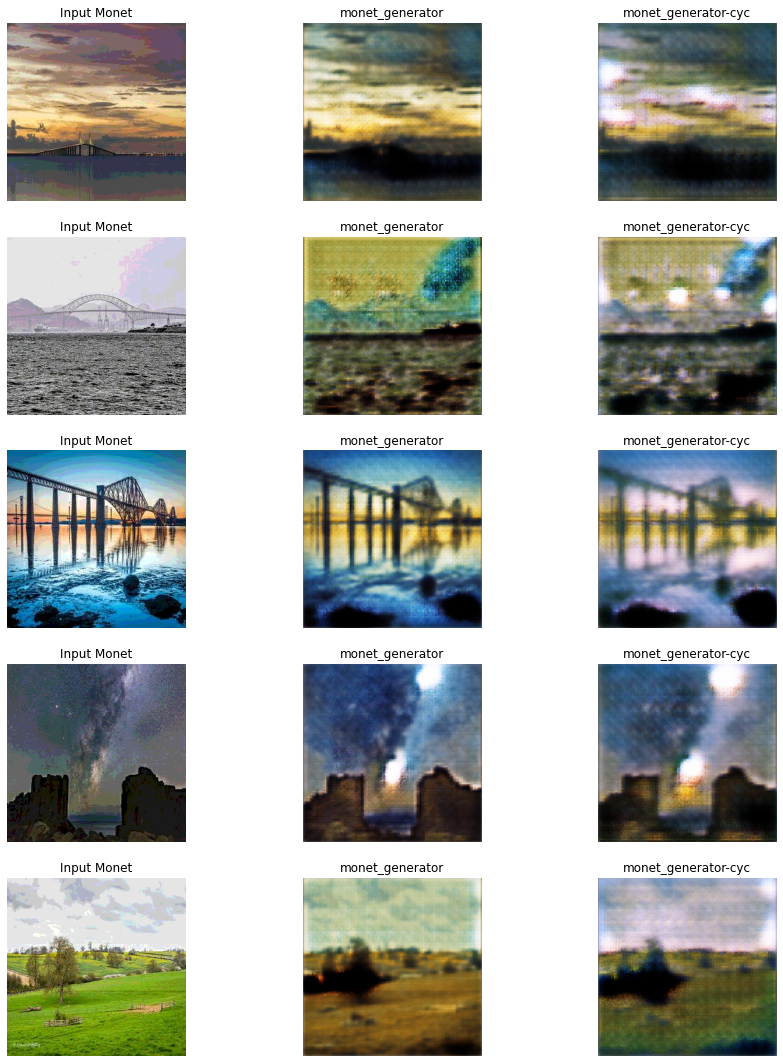

In [50]:
_, ax = plt.subplots(5, 3, figsize=(15, 19))

for i, img in enumerate(monet_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    print('monet_generator', prediction.min(), prediction.max())
    
    prediction_m = prediction.reshape((1, 256, 256, 3))
    prediction_c = photo_generator(prediction_m, training=False)[0].numpy()
    print('photo_generator', prediction_c.min(), prediction_c.max())
    
    prediction_c = prediction_c.reshape((1, 256, 256, 3))
    monet_prediction = monet_generator(prediction_c, training=False)[0].numpy()
    print('monet_generator', monet_prediction.min(), monet_prediction.max())
    monet_prediction = (monet_prediction * 255).astype(np.uint8)
    print()
    img = (img[0] * 255).numpy().astype(np.uint8)
    prediction = (prediction  * 255).astype(np.uint8)
    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(monet_prediction)
    ax[i, 0].set_title("Input Monet")
    ax[i, 1].set_title("monet_generator")
    ax[i, 2].set_title("monet_generator-cyc")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()

# Create submission file

In [51]:
"""import PIL

! mkdir ./images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./images/" + str(i) + ".jpg")
    i += 1
    
import shutil

shutil.make_archive("./images", 'zip', "./")
"""

'import PIL\n\n! mkdir ./images\n\ni = 1\nfor img in photo_ds:\n    prediction = monet_generator(img, training=False)[0].numpy()\n    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)\n    im = PIL.Image.fromarray(prediction)\n    im.save("./images/" + str(i) + ".jpg")\n    i += 1\n    \nimport shutil\n\nshutil.make_archive("./images", \'zip\', "./")\n'

In [ ]:
!pip install imutils

from IPython.display import Video

import datetime
import cv2
import time
import subprocess as sp
import multiprocessing as mp
from os import remove
import imutils

def process_video(input_file_name, output_file_name):
    # Read video file
    cap = cv2.VideoCapture(input_file_name)
    
#     #######################################################################
#     cap.set(cv2.CAP_PROP_POS_FRAMES, 2128) # SUPIMER, Start from frame 3248
#     #######################################################################
    
    # get height, width and frame count of the video
    width, height = (
            int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        )
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print("original fps : ", fps)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID') # for .avi format
    out = cv2.VideoWriter(output_file_name, fourcc, fps, (width, height), True)
    frm_indx = 0
    # Read until video is completed
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            # Create a copy of the original frame to modify
            detection_frame = frame.copy()
            detection_frame = cv2.resize(detection_frame, (256, 256))
#             detection_frame = (detection_frame/127.5)-1 # if tfrecords
            detection_frame = (detection_frame/255) # if jpegs
            detection_frame = detection_frame.reshape((1, 256, 256, 3))
            detection_frame = monet_generator(detection_frame, training=False)[0].numpy()
#             detection_frame = (detection_frame * 127.5 + 127.5).astype(np.uint8) # photo to monet, reactivate this
                        
            detection_frame = detection_frame.reshape((1, 256, 256, 3)) # photo to photo
            detection_frame = photo_generator(detection_frame, training=False)[0].numpy() # photo to photo
            detection_frame = (detection_frame * 255).astype(np.uint8) # photo to photo
          
            detection_frame = cv2.resize(detection_frame.squeeze(), (int(cap.get(3)), int(cap.get(4))))
                
            # Write the processed frame to the output video
            out.write(detection_frame)
            
#             detection_frame = detection_frame[:, :, ::-1]
#             plt.imshow(detection_frame)
#             plt.show()
        
    

        else:
            break
            
#         frm_indx += 1
#         if frm_indx == 228:
#                 break  
    
    # Release the video capture and video write objects
    cap.release()
    out.release()
    

def get_video_frame_details(file_name):
    # Open the video
    data = cv2.VideoCapture(file_name)
    # count the number of frames 
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT) 
    fps = data.get(cv2.CAP_PROP_FPS) 

    # calculate duration of the video 
    seconds = round(frames / fps) 
    video_time = datetime.timedelta(seconds=seconds) 
    print(f"duration in seconds: {seconds}") 
    print(f"video time: {video_time}") 
    return int(data.get(3)), int(data.get(4)), frames

def single_process(input_file_name, output_file_name):
    print("Video processing using single process...")
    start_time = time.time()
    process_video(input_file_name, output_file_name)
    end_time = time.time()
    total_processing_time = end_time - start_time
    print("Time taken: {}".format(total_processing_time))
    print("FPS : {}".format(frame_count/total_processing_time))
    
    
in_file_name = "/kaggle/input/bts-ep-1-ep-2-ep131/EP.1.v0.1703088915.1080p.mp4"
out_file_name = "./output_single2.avi"
width, height, frame_count = get_video_frame_details(in_file_name)
print("Video frame count = {}".format(frame_count))
print("Width = {}, Height = {}".format(width, height))

single_process(in_file_name, out_file_name)

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=92f791f88b3311ba54ca56f6cefc676916def0d05dec82c05f7f343cc0f3104e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
duration in seconds: 1953
video time: 0:32:33
Video frame count = 46818.0
Width = 1920, Height = 1080
Video processing using single process...
original fps :  23


In [ ]:
# Convert the .avi video generated by our traffic density estimation app to .mp4 format for compatibility with notebook display
!ffmpeg -y -loglevel panic -i /kaggle/working/output_single2.avi /kaggle/working/BTS_ep_3_epochs_monet.mp4

# Embed and display the processed sample video within the notebook
Video("/kaggle/working/BTS_ep_3_epochs_monet.mp4", embed=True, width=760)

<a href="./BTS_ep_3_35epochs_monet.mp4">BTS_ep_3_35epochs_monet.mp4</a>

___
___
___

___
___
___

# PAINT TRANSFORM

In [ ]:
%cd /content
!git clone https://github.com/lucabeetz/PaintTransformer.git
%cd PaintTransformer/inference

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import morphology
import network
import os
import math
import matplotlib.pyplot as plt

idx = 0


def save_img(img, output_path):
    result = Image.fromarray(
        (img.data.cpu().numpy().transpose((1, 2, 0)) * 255).astype(np.uint8))
    result.save(output_path)


def param2stroke(param, H, W, meta_brushes):
    """
    Input a set of stroke parameters and output its corresponding foregrounds and alpha maps.
    Args:
        param: a tensor with shape n_strokes x n_param_per_stroke. Here, param_per_stroke is 8:
        x_center, y_center, width, height, theta, R, G, and B.
        H: output height.
        W: output width.
        meta_brushes: a tensor with shape 2 x 3 x meta_brush_height x meta_brush_width.
         The first slice on the batch dimension denotes vertical brush and the second one denotes horizontal brush.

    Returns:
        foregrounds: a tensor with shape n_strokes x 3 x H x W, containing color information.
        alphas: a tensor with shape n_strokes x 3 x H x W,
         containing binary information of whether a pixel is belonging to the stroke (alpha mat), for painting process.
    """
    # Firstly, resize the meta brushes to the required shape,
    # in order to decrease GPU memory especially when the required shape is small.
    meta_brushes_resize = F.interpolate(meta_brushes, (H, W))
    b = param.shape[0]

    # Extract shape parameters and color parameters.
    param_list = torch.split(param, 1, dim=1)
    x0, y0, w, h, theta = [item.squeeze(-1) for item in param_list[:5]]
    R, G, B = param_list[5:]
    # Pre-compute sin theta and cos theta
    sin_theta = torch.sin(torch.acos(
        torch.tensor(-1., device=param.device)) * theta)
    cos_theta = torch.cos(torch.acos(
        torch.tensor(-1., device=param.device)) * theta)
    # index means each stroke should use which meta stroke? Vertical meta stroke or horizontal meta stroke.
    # When h > w, vertical stroke should be used. When h <= w, horizontal stroke should be used.
    index = torch.full((b,), -1, device=param.device, dtype=torch.long)
    index[h > w] = 0
    index[h <= w] = 1
    brush = meta_brushes_resize[index.long()]

    # Calculate warp matrix according to the rules defined by pytorch, in order for warping.
    warp_00 = cos_theta / w
    warp_01 = sin_theta * H / (W * w)
    warp_02 = (1 - 2 * x0) * cos_theta / w + \
        (1 - 2 * y0) * sin_theta * H / (W * w)
    warp_10 = -sin_theta * W / (H * h)
    warp_11 = cos_theta / h
    warp_12 = (1 - 2 * y0) * cos_theta / h - \
        (1 - 2 * x0) * sin_theta * W / (H * h)
    warp_0 = torch.stack([warp_00, warp_01, warp_02], dim=1)
    warp_1 = torch.stack([warp_10, warp_11, warp_12], dim=1)
    warp = torch.stack([warp_0, warp_1], dim=1)
    # Conduct warping.
    grid = F.affine_grid(warp, [b, 3, H, W], align_corners=False)
    brush = F.grid_sample(brush, grid, align_corners=False)
    # alphas is the binary information suggesting whether a pixel is belonging to the stroke.
    alphas = (brush > 0).float()
    brush = brush.repeat(1, 3, 1, 1)
    alphas = alphas.repeat(1, 3, 1, 1)
    # Give color to foreground strokes.
    color_map = torch.cat([R, G, B], dim=1)
    color_map = color_map.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, H, W)
    foreground = brush * color_map
    # Dilation and erosion are used for foregrounds and alphas respectively to prevent artifacts on stroke borders.
    foreground = morphology.dilation(foreground)
    alphas = morphology.erosion(alphas)
    return foreground, alphas


def param2img_serial(
        param, decision, meta_brushes, cur_canvas, frame_dir, has_border=False, original_h=None, original_w=None):
    """
    Input stroke parameters and decisions for each patch, meta brushes, current canvas, frame directory,
    and whether there is a border (if intermediate painting results are required).
    Output the painting results of adding the corresponding strokes on the current canvas.
    Args:
        param: a tensor with shape batch size x patch along height dimension x patch along width dimension
         x n_stroke_per_patch x n_param_per_stroke
        decision: a 01 tensor with shape batch size x patch along height dimension x patch along width dimension
         x n_stroke_per_patch
        meta_brushes: a tensor with shape 2 x 3 x meta_brush_height x meta_brush_width.
        The first slice on the batch dimension denotes vertical brush and the second one denotes horizontal brush.
        cur_canvas: a tensor with shape batch size x 3 x H x W,
         where H and W denote height and width of padded results of original images.
        frame_dir: directory to save intermediate painting results. None means intermediate results are not required.
        has_border: on the last painting layer, in order to make sure that the painting results do not miss
         any important detail, we choose to paint again on this layer but shift patch_size // 2 pixels when
         cutting patches. In this case, if intermediate results are required, we need to cut the shifted length
         on the border before saving, or there would be a black border.
        original_h: to indicate the original height for cropping when saving intermediate results.
        original_w: to indicate the original width for cropping when saving intermediate results.

    Returns:
        cur_canvas: a tensor with shape batch size x 3 x H x W, denoting painting results.
    """
    # param: b, h, w, stroke_per_patch, param_per_stroke
    # decision: b, h, w, stroke_per_patch
    b, h, w, s, p = param.shape
    H, W = cur_canvas.shape[-2:]
    is_odd_y = h % 2 == 1
    is_odd_x = w % 2 == 1
    patch_size_y = 2 * H // h
    patch_size_x = 2 * W // w
    even_idx_y = torch.arange(0, h, 2, device=cur_canvas.device)
    even_idx_x = torch.arange(0, w, 2, device=cur_canvas.device)
    odd_idx_y = torch.arange(1, h, 2, device=cur_canvas.device)
    odd_idx_x = torch.arange(1, w, 2, device=cur_canvas.device)
    even_y_even_x_coord_y, even_y_even_x_coord_x = torch.meshgrid(
        [even_idx_y, even_idx_x])
    odd_y_odd_x_coord_y, odd_y_odd_x_coord_x = torch.meshgrid(
        [odd_idx_y, odd_idx_x])
    even_y_odd_x_coord_y, even_y_odd_x_coord_x = torch.meshgrid(
        [even_idx_y, odd_idx_x])
    odd_y_even_x_coord_y, odd_y_even_x_coord_x = torch.meshgrid(
        [odd_idx_y, even_idx_x])
    cur_canvas = F.pad(cur_canvas, [patch_size_x // 4, patch_size_x // 4,
                                    patch_size_y // 4, patch_size_y // 4, 0, 0, 0, 0])

    def partial_render(this_canvas, patch_coord_y, patch_coord_x, stroke_id):
        canvas_patch = F.unfold(this_canvas, (patch_size_y, patch_size_x),
                                stride=(patch_size_y // 2, patch_size_x // 2))
        # canvas_patch: b, 3 * py * px, h * w
        canvas_patch = canvas_patch.view(
            b, 3, patch_size_y, patch_size_x, h, w).contiguous()
        canvas_patch = canvas_patch.permute(0, 4, 5, 1, 2, 3).contiguous()
        # canvas_patch: b, h, w, 3, py, px
        selected_canvas_patch = canvas_patch[:,
                                             patch_coord_y, patch_coord_x, :, :, :]
        selected_h, selected_w = selected_canvas_patch.shape[1:3]
        selected_param = param[:, patch_coord_y,
                               patch_coord_x, stroke_id, :].view(-1, p).contiguous()
        selected_decision = decision[:, patch_coord_y,
                                     patch_coord_x, stroke_id].view(-1).contiguous()
        selected_foregrounds = torch.zeros(selected_param.shape[0], 3, patch_size_y, patch_size_x,
                                           device=this_canvas.device)
        selected_alphas = torch.zeros(
            selected_param.shape[0], 3, patch_size_y, patch_size_x, device=this_canvas.device)
        if selected_param[selected_decision, :].shape[0] > 0:
            selected_foregrounds[selected_decision, :, :, :], selected_alphas[selected_decision, :, :, :] = \
                param2stroke(
                    selected_param[selected_decision, :], patch_size_y, patch_size_x, meta_brushes)
        selected_foregrounds = selected_foregrounds.view(
            b, selected_h, selected_w, 3, patch_size_y, patch_size_x).contiguous()
        selected_alphas = selected_alphas.view(
            b, selected_h, selected_w, 3, patch_size_y, patch_size_x).contiguous()
        selected_decision = selected_decision.view(
            b, selected_h, selected_w, 1, 1, 1).contiguous()
        selected_canvas_patch = selected_foregrounds * selected_alphas * selected_decision + selected_canvas_patch * (
            1 - selected_alphas * selected_decision)
        this_canvas = selected_canvas_patch.permute(
            0, 3, 1, 4, 2, 5).contiguous()
        # this_canvas: b, 3, selected_h, py, selected_w, px
        this_canvas = this_canvas.view(
            b, 3, selected_h * patch_size_y, selected_w * patch_size_x).contiguous()
        # this_canvas: b, 3, selected_h * py, selected_w * px
        return this_canvas

    global idx
    if has_border:
        factor = 2
    else:
        factor = 4
    if even_idx_y.shape[0] > 0 and even_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(
                cur_canvas, even_y_even_x_coord_y, even_y_even_x_coord_x, i)
            if not is_odd_y:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
            if not is_odd_x:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                                        patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    if odd_idx_y.shape[0] > 0 and odd_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(
                cur_canvas, odd_y_odd_x_coord_y, odd_y_odd_x_coord_x, i)
            canvas = torch.cat(
                [cur_canvas[:, :, :patch_size_y // 2, -canvas.shape[3]:], canvas], dim=2)
            canvas = torch.cat(
                [cur_canvas[:, :, -canvas.shape[2]:, :patch_size_x // 2], canvas], dim=3)
            if is_odd_y:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
            if is_odd_x:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                                        patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    if odd_idx_y.shape[0] > 0 and even_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(
                cur_canvas, odd_y_even_x_coord_y, odd_y_even_x_coord_x, i)
            canvas = torch.cat(
                [cur_canvas[:, :, :patch_size_y // 2, :canvas.shape[3]], canvas], dim=2)
            if is_odd_y:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
            if not is_odd_x:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                                        patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    if even_idx_y.shape[0] > 0 and odd_idx_x.shape[0] > 0:
        for i in range(s):
            canvas = partial_render(
                cur_canvas, even_y_odd_x_coord_y, even_y_odd_x_coord_x, i)
            canvas = torch.cat(
                [cur_canvas[:, :, :canvas.shape[2], :patch_size_x // 2], canvas], dim=3)
            if not is_odd_y:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, -patch_size_y // 2:, -canvas.shape[3]:]], dim=2)
            if is_odd_x:
                canvas = torch.cat(
                    [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
            cur_canvas = canvas
            idx += 1
            if frame_dir is not None:
                frame = crop(cur_canvas[:, :, patch_size_y // factor:-patch_size_y // factor,
                                        patch_size_x // factor:-patch_size_x // factor], original_h, original_w)
                save_img(frame[0], os.path.join(frame_dir, '%03d.jpg' % idx))

    cur_canvas = cur_canvas[:, :, patch_size_y // 4:-
                            patch_size_y // 4, patch_size_x // 4:-patch_size_x // 4]

    return cur_canvas


def param2img_parallel(param, decision, meta_brushes, cur_canvas):
    """
        Input stroke parameters and decisions for each patch, meta brushes, current canvas, frame directory,
        and whether there is a border (if intermediate painting results are required).
        Output the painting results of adding the corresponding strokes on the current canvas.
        Args:
            param: a tensor with shape batch size x patch along height dimension x patch along width dimension
             x n_stroke_per_patch x n_param_per_stroke
            decision: a 01 tensor with shape batch size x patch along height dimension x patch along width dimension
             x n_stroke_per_patch
            meta_brushes: a tensor with shape 2 x 3 x meta_brush_height x meta_brush_width.
            The first slice on the batch dimension denotes vertical brush and the second one denotes horizontal brush.
            cur_canvas: a tensor with shape batch size x 3 x H x W,
             where H and W denote height and width of padded results of original images.

        Returns:
            cur_canvas: a tensor with shape batch size x 3 x H x W, denoting painting results.
        """
    # param: b, h, w, stroke_per_patch, param_per_stroke
    # decision: b, h, w, stroke_per_patch
    b, h, w, s, p = param.shape

    param = param.view(-1, 8).contiguous()

    decision = decision.view(-1).contiguous().bool()
    if sum(decision).item()==0:
        decision = decision+1
        decision = decision.bool()
    H, W = cur_canvas.shape[-2:]
    is_odd_y = h % 2 == 1
    is_odd_x = w % 2 == 1
    patch_size_y = 2 * H // h
    patch_size_x = 2 * W // w
    even_idx_y = torch.arange(0, h, 2, device=cur_canvas.device)
    even_idx_x = torch.arange(0, w, 2, device=cur_canvas.device)
    odd_idx_y = torch.arange(1, h, 2, device=cur_canvas.device)
    odd_idx_x = torch.arange(1, w, 2, device=cur_canvas.device)
    even_y_even_x_coord_y, even_y_even_x_coord_x = torch.meshgrid(
        [even_idx_y, even_idx_x])
    odd_y_odd_x_coord_y, odd_y_odd_x_coord_x = torch.meshgrid(
        [odd_idx_y, odd_idx_x])
    even_y_odd_x_coord_y, even_y_odd_x_coord_x = torch.meshgrid(
        [even_idx_y, odd_idx_x])
    odd_y_even_x_coord_y, odd_y_even_x_coord_x = torch.meshgrid(
        [odd_idx_y, even_idx_x])
    cur_canvas = F.pad(cur_canvas, [patch_size_x // 4, patch_size_x // 4,
                                    patch_size_y // 4, patch_size_y // 4, 0, 0, 0, 0])
    foregrounds = torch.zeros(
        param.shape[0], 3, patch_size_y, patch_size_x, device=cur_canvas.device)
    alphas = torch.zeros(
        param.shape[0], 3, patch_size_y, patch_size_x, device=cur_canvas.device)

    valid_foregrounds, valid_alphas = param2stroke(
        param[decision, :], patch_size_y, patch_size_x, meta_brushes)
    foregrounds[decision, :, :, :] = valid_foregrounds
    alphas[decision, :, :, :] = valid_alphas
    # foreground, alpha: b * h * w * stroke_per_patch, 3, patch_size_y, patch_size_x
    foregrounds = foregrounds.view(-1, h, w, s,
                                   3, patch_size_y, patch_size_x).contiguous()
    alphas = alphas.view(-1, h, w, s, 3, patch_size_y,
                         patch_size_x).contiguous()
    # foreground, alpha: b, h, w, stroke_per_patch, 3, render_size_y, render_size_x
    decision = decision.view(-1, h, w, s, 1, 1, 1).contiguous()

    # decision: b, h, w, stroke_per_patch, 1, 1, 1

    def partial_render(this_canvas, patch_coord_y, patch_coord_x):

        canvas_patch = F.unfold(this_canvas, (patch_size_y, patch_size_x),
                                stride=(patch_size_y // 2, patch_size_x // 2))
        # canvas_patch: b, 3 * py * px, h * w
        canvas_patch = canvas_patch.view(
            b, 3, patch_size_y, patch_size_x, h, w).contiguous()
        canvas_patch = canvas_patch.permute(0, 4, 5, 1, 2, 3).contiguous()
        # canvas_patch: b, h, w, 3, py, px
        selected_canvas_patch = canvas_patch[:,
                                             patch_coord_y, patch_coord_x, :, :, :]
        selected_foregrounds = foregrounds[:,
                                           patch_coord_y, patch_coord_x, :, :, :, :]
        selected_alphas = alphas[:, patch_coord_y, patch_coord_x, :, :, :, :]
        selected_decisions = decision[:,
                                      patch_coord_y, patch_coord_x, :, :, :, :]
        for i in range(s):
            cur_foreground = selected_foregrounds[:, :, :, i, :, :, :]
            cur_alpha = selected_alphas[:, :, :, i, :, :, :]
            cur_decision = selected_decisions[:, :, :, i, :, :, :]
            selected_canvas_patch = cur_foreground * cur_alpha * cur_decision + selected_canvas_patch * (
                1 - cur_alpha * cur_decision)
        this_canvas = selected_canvas_patch.permute(
            0, 3, 1, 4, 2, 5).contiguous()
        # this_canvas: b, 3, h_half, py, w_half, px
        h_half = this_canvas.shape[2]
        w_half = this_canvas.shape[4]
        this_canvas = this_canvas.view(
            b, 3, h_half * patch_size_y, w_half * patch_size_x).contiguous()
        # this_canvas: b, 3, h_half * py, w_half * px
        return this_canvas

    if even_idx_y.shape[0] > 0 and even_idx_x.shape[0] > 0:
        canvas = partial_render(
            cur_canvas, even_y_even_x_coord_y, even_y_even_x_coord_x)
        if not is_odd_y:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
        if not is_odd_x:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
        cur_canvas = canvas

    if odd_idx_y.shape[0] > 0 and odd_idx_x.shape[0] > 0:
        canvas = partial_render(
            cur_canvas, odd_y_odd_x_coord_y, odd_y_odd_x_coord_x)
        canvas = torch.cat(
            [cur_canvas[:, :, :patch_size_y // 2, -canvas.shape[3]:], canvas], dim=2)
        canvas = torch.cat(
            [cur_canvas[:, :, -canvas.shape[2]:, :patch_size_x // 2], canvas], dim=3)
        if is_odd_y:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
        if is_odd_x:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
        cur_canvas = canvas

    if odd_idx_y.shape[0] > 0 and even_idx_x.shape[0] > 0:
        canvas = partial_render(
            cur_canvas, odd_y_even_x_coord_y, odd_y_even_x_coord_x)
        canvas = torch.cat(
            [cur_canvas[:, :, :patch_size_y // 2, :canvas.shape[3]], canvas], dim=2)
        if is_odd_y:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, -patch_size_y // 2:, :canvas.shape[3]]], dim=2)
        if not is_odd_x:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
        cur_canvas = canvas

    if even_idx_y.shape[0] > 0 and odd_idx_x.shape[0] > 0:
        canvas = partial_render(
            cur_canvas, even_y_odd_x_coord_y, even_y_odd_x_coord_x)
        canvas = torch.cat(
            [cur_canvas[:, :, :canvas.shape[2], :patch_size_x // 2], canvas], dim=3)
        if not is_odd_y:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, -patch_size_y // 2:, -canvas.shape[3]:]], dim=2)
        if is_odd_x:
            canvas = torch.cat(
                [canvas, cur_canvas[:, :, :canvas.shape[2], -patch_size_x // 2:]], dim=3)
        cur_canvas = canvas

    cur_canvas = cur_canvas[:, :, patch_size_y // 4:-
                            patch_size_y // 4, patch_size_x // 4:-patch_size_x // 4]

    return cur_canvas


def read_img(img_path, img_type='RGB', h=None, w=None):
    img = Image.open(img_path).convert(img_type)
    if h is not None and w is not None:
        img = img.resize((w, h), resample=Image.NEAREST)
    img = np.array(img)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    img = img.transpose((2, 0, 1))
    img = torch.from_numpy(img).unsqueeze(0).float() / 255.
    return img


def pad(img, H, W):
    b, c, h, w = img.shape
#     c, h, w = img.shape
#     b=1
    pad_h = (H - h) // 2
    pad_w = (W - w) // 2
    remainder_h = (H - h) % 2
    remainder_w = (W - w) % 2
    img = torch.cat([torch.zeros((b, c, pad_h, w), device=img.device), img,
                     torch.zeros((b, c, pad_h + remainder_h, w), device=img.device)], dim=-2)
    img = torch.cat([torch.zeros((b, c, H, pad_w), device=img.device), img,
                     torch.zeros((b, c, H, pad_w + remainder_w), device=img.device)], dim=-1)
    return img


def crop(img, h, w):
    H, W = img.shape[-2:]
    pad_h = (H - h) // 2
    pad_w = (W - w) // 2
    remainder_h = (H - h) % 2
    remainder_w = (W - w) % 2
    img = img[:, :, pad_h:H - pad_h - remainder_h,
              pad_w:W - pad_w - remainder_w]
    return img


def run_inference(original_img, input_name, net_g, stroke_num, output_dir, need_animation=False, resize_h=None, resize_w=None, serial=False, device="cpu"):
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
#     input_name = os.path.basename(input_path)
    output_path = os.path.join(output_dir, input_name)
    frame_dir = None
    if need_animation:
        if not serial:
            print(
                'It must be under serial mode if animation results are required, so serial flag is set to True!')
            serial = True
        frame_dir = os.path.join(output_dir, input_name[:input_name.find('.')])
        if not os.path.exists(frame_dir):
            os.mkdir(frame_dir)
    patch_size = 32
#     stroke_num = 8
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net_g = network.Painter(5, stroke_num, 256, 8, 3, 3).to(device)
#     net_g.load_state_dict(torch.load(model_path))
#     net_g.eval()
#     for param in net_g.parameters():
#         param.requires_grad = False

    brush_large_vertical = read_img(
        'brush/brush_large_vertical.png', 'L').to(device)
    brush_large_horizontal = read_img(
        'brush/brush_large_horizontal.png', 'L').to(device)
    meta_brushes = torch.cat(
        [brush_large_vertical, brush_large_horizontal], dim=0)

    with torch.no_grad():
#         original_img = read_img(
#             input_path, 'RGB', resize_h, resize_w).to(device)
        original_h, original_w = original_img.shape[-2:]
        K = max(math.ceil(math.log2(max(original_h, original_w) / patch_size)), 0)
        original_img_pad_size = patch_size * (2 ** K)
        original_img_pad = pad(
            original_img, original_img_pad_size, original_img_pad_size)
        final_result = torch.zeros_like(original_img_pad).to(device)
        for layer in range(0, K + 1):
            layer_size = patch_size * (2 ** layer)
            img = F.interpolate(original_img_pad, (layer_size, layer_size))
            result = F.interpolate(
                final_result, (patch_size * (2 ** layer), patch_size * (2 ** layer)))
            img_patch = F.unfold(img, (patch_size, patch_size),
                                 stride=(patch_size, patch_size))
            result_patch = F.unfold(result, (patch_size, patch_size),
                                    stride=(patch_size, patch_size))
            # There are patch_num * patch_num patches in total
            patch_num = (layer_size - patch_size) // patch_size + 1

            # img_patch, result_patch: b, 3 * output_size * output_size, h * w
            img_patch = img_patch.permute(0, 2, 1).contiguous(
            ).view(-1, 3, patch_size, patch_size).contiguous()
            result_patch = result_patch.permute(0, 2, 1).contiguous().view(
                -1, 3, patch_size, patch_size).contiguous()
            shape_param, stroke_decision = net_g(img_patch, result_patch)
            stroke_decision = network.SignWithSigmoidGrad.apply(
                stroke_decision)

            grid = shape_param[:, :, :2].view(
                img_patch.shape[0] * stroke_num, 1, 1, 2).contiguous()
            img_temp = img_patch.unsqueeze(1).contiguous().repeat(1, stroke_num, 1, 1, 1).view(
                img_patch.shape[0] * stroke_num, 3, patch_size, patch_size).contiguous()
            color = F.grid_sample(img_temp, 2 * grid - 1, align_corners=False).view(
                img_patch.shape[0], stroke_num, 3).contiguous()
            stroke_param = torch.cat([shape_param, color], dim=-1)
            # stroke_param: b * h * w, stroke_per_patch, param_per_stroke
            # stroke_decision: b * h * w, stroke_per_patch, 1
            param = stroke_param.view(
                1, patch_num, patch_num, stroke_num, 8).contiguous()
            decision = stroke_decision.view(
                1, patch_num, patch_num, stroke_num).contiguous().bool()
            # param: b, h, w, stroke_per_patch, 8
            # decision: b, h, w, stroke_per_patch
            param[..., :2] = param[..., :2] / 2 + 0.25
            param[..., 2:4] = param[..., 2:4] / 2
            if serial:
                final_result = param2img_serial(param, decision, meta_brushes, final_result,
                                                frame_dir, False, original_h, original_w)
            else:
                final_result = param2img_parallel(
                    param, decision, meta_brushes, final_result)

        border_size = original_img_pad_size // (2 * patch_num)
        img = F.interpolate(
            original_img_pad, (patch_size * (2 ** layer), patch_size * (2 ** layer)))
        result = F.interpolate(
            final_result, (patch_size * (2 ** layer), patch_size * (2 ** layer)))
        img = F.pad(img, [patch_size // 2, patch_size // 2, patch_size // 2, patch_size // 2,
                          0, 0, 0, 0])
        result = F.pad(result, [patch_size // 2, patch_size // 2, patch_size // 2, patch_size // 2,
                                0, 0, 0, 0])
        img_patch = F.unfold(img, (patch_size, patch_size),
                             stride=(patch_size, patch_size))
        result_patch = F.unfold(
            result, (patch_size, patch_size), stride=(patch_size, patch_size))
        final_result = F.pad(
            final_result, [border_size, border_size, border_size, border_size, 0, 0, 0, 0])
        h = (img.shape[2] - patch_size) // patch_size + 1
        w = (img.shape[3] - patch_size) // patch_size + 1
        # img_patch, result_patch: b, 3 * output_size * output_size, h * w
        img_patch = img_patch.permute(0, 2, 1).contiguous(
        ).view(-1, 3, patch_size, patch_size).contiguous()
        result_patch = result_patch.permute(0, 2, 1).contiguous(
        ).view(-1, 3, patch_size, patch_size).contiguous()
        shape_param, stroke_decision = net_g(img_patch, result_patch)

        grid = shape_param[:, :, :2].view(
            img_patch.shape[0] * stroke_num, 1, 1, 2).contiguous()
        img_temp = img_patch.unsqueeze(1).contiguous().repeat(1, stroke_num, 1, 1, 1).view(
            img_patch.shape[0] * stroke_num, 3, patch_size, patch_size).contiguous()
        color = F.grid_sample(img_temp, 2 * grid - 1, align_corners=False).view(
            img_patch.shape[0], stroke_num, 3).contiguous()
        stroke_param = torch.cat([shape_param, color], dim=-1)
        # stroke_param: b * h * w, stroke_per_patch, param_per_stroke
        # stroke_decision: b * h * w, stroke_per_patch, 1
        param = stroke_param.view(1, h, w, stroke_num, 8).contiguous()
        decision = stroke_decision.view(
            1, h, w, stroke_num).contiguous().bool()
        # param: b, h, w, stroke_per_patch, 8
        # decision: b, h, w, stroke_per_patch
        param[..., :2] = param[..., :2] / 2 + 0.25
        param[..., 2:4] = param[..., 2:4] / 2
        if serial:
            final_result = param2img_serial(param, decision, meta_brushes, final_result,
                                            frame_dir, True, original_h, original_w)
        else:
            final_result = param2img_parallel(
                param, decision, meta_brushes, final_result)
        final_result = final_result[:, :, border_size:-
                                    border_size, border_size:-border_size]

        final_result = crop(final_result, original_h, original_w)
#         save_img(final_result[0], output_path)
        return final_result[0]

In [ ]:
# from inference import run_inference

input_img = 'input/chicago.jpg'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize_h = None
resize_w=None
original_img = read_img(
            input_img, 'RGB', resize_h, resize_w).to(device)
print("image size:", original_img.shape)
input_name = os.path.basename(input_img)
model_path='model.pth'
stroke_num = 8
net_g = network.Painter(5, stroke_num, 256, 8, 3, 3).to(device)
net_g.load_state_dict(torch.load(model_path))
net_g.eval()
for param in net_g.parameters():
        param.requires_grad = False
        
pt_img = run_inference(original_img=original_img,
              input_name=input_name,
              net_g=net_g,
              stroke_num=stroke_num,
              output_dir='output/', # whether need intermediate results for animation.
#               need_animation=True,  # resize original input to this size. None means do not resize.
              resize_h=resize_h,        # resize original input to this size. None means do not resize.
              resize_w=resize_w,
              serial=False,      # if need animation, serial must be True.
              device=device)         

plt.imshow(pt_img.cpu().numpy().transpose(1,2,0))
plt.show()

In [ ]:
"""# Create GIF from individual steps
import glob
from PIL import Image

# Set to dir with output images
in_dir = 'output/chicago/*.jpg'
out_path = 'output/chicago.gif'

img, *imgs = [Image.open(f) for f in sorted(glob.glob(in_dir))]
img.save(fp=out_path, format='GIF', append_images=imgs,
          save_all=True, duration=100, loop=0)"""

In [ ]:
!pip install imutils

In [ ]:
from IPython.display import Video

import datetime
import cv2
import time
import subprocess as sp
import multiprocessing as mp
from os import remove
import imutils

def process_video(input_file_name, output_file_name):
    # Read video file
    cap = cv2.VideoCapture(input_file_name)
    
#     #######################################################################
    cap.set(cv2.CAP_PROP_POS_FRAMES, 8) # SUPIMER, Start from frame 3248
#     #######################################################################
    
    # get height, width and frame count of the video
    width, height = (
            int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        )
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print("original fps : ", fps)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID') # for .avi format
    out = cv2.VideoWriter(output_file_name, fourcc, fps, (width, height), True)
    frm_indx = 0
    
#     stroke_num = 8
#     net_g = network.Painter(5, stroke_num, 256, 8, 3, 3).to(device)
#     net_g.load_state_dict(torch.load('model.pth'))
#     net_g.eval()
#     for param in net_g.parameters():
#         param.requires_grad = False
        
        
    # Read until video is completed
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()

        if ret:
            # Create a copy of the original frame to modify
            detection_frame = frame.copy()
            
            detection_frame = cv2.resize(detection_frame, (712, 474))
            detection_frame = detection_frame.transpose((2, 0, 1))
            detection_frame = np.expand_dims(detection_frame, 0)
            detection_frame = torch.from_numpy(detection_frame).float() / 255.
            
            detection_frame = detection_frame.to(device)
            detection_frame =  run_inference(original_img=detection_frame,
              input_name="input_name.jpg",
              net_g=net_g,
              stroke_num=stroke_num,
              output_dir='output/', 
              resize_h=None,        
              resize_w=None,
              serial=False,    
              device=device)  
            detection_frame = detection_frame.cpu().numpy().squeeze().transpose(1,2,0)
            detection_frame = cv2.resize(detection_frame, (int(cap.get(3)), int(cap.get(4))))
            
            detection_frame = (detection_frame*255).astype(np.uint8) #detection_frame[:, :, ::-1]
            
            plt.imshow(detection_frame)
            plt.show()
            
            
# #             # Write the processed frame to the output video
            out.write(detection_frame)



        else:
            break
        frm_indx += 1
        if frm_indx == 50:
                break  
    # Release the video capture and video write objects
    cap.release()
    out.release()
    return detection_frame
    

def get_video_frame_details(file_name):
    # Open the video
    data = cv2.VideoCapture(file_name)
    # count the number of frames 
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT) 
    fps = data.get(cv2.CAP_PROP_FPS) 

    # calculate duration of the video 
    seconds = round(frames / fps) 
    video_time = datetime.timedelta(seconds=seconds) 
    print(f"duration in seconds: {seconds}") 
    print(f"video time: {video_time}") 
    return int(data.get(3)), int(data.get(4)), frames

def single_process(input_file_name, output_file_name):
    print("Video processing using single process...")
    start_time = time.time()
    process_video(input_file_name, output_file_name)
    end_time = time.time()
    total_processing_time = end_time - start_time
    print("Time taken: {}".format(total_processing_time))
    print("FPS : {}".format(frame_count/total_processing_time))
    
    
in_file_name = "/kaggle/input/bts-ep-1-ep-2-ep131/EP.1.v0.1703088915.1080p.mp4"
out_file_name = "./output_single.avi"
width, height, frame_count = get_video_frame_details(in_file_name)
print("Video frame count = {}".format(frame_count))
print("Width = {}, Height = {}".format(width, height))

detection_frame = single_process(in_file_name, out_file_name)

In [ ]:
# Convert the .avi video generated by our traffic density estimation app to .mp4 format for compatibility with notebook display
!ffmpeg -y -loglevel panic -i /kaggle/working/PaintTransformer/inference/output_single.avi /kaggle/working/PaintTransformer.mp4

# Embed and display the processed sample video within the notebook
Video("/kaggle/working/PaintTransformer.mp4", embed=True, width=760)